# 基本信息
在训练集或者验证集中标注了目标信息，可以计算

1、目标的类别

2、目标的尺寸位置(y1,x1,y2,x2)

3、目标的面积

4、宽高比

5、目标的多边形面积

6、面积比

In [1]:
# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
import os, json
import numpy as np
import skimage.draw
import math
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize

# Path to data set
DATASET = "D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\\"

class MyConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mask"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # Background + my

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 800  
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_SCALE = 0

    # BACKBONE = "resnet50"
    # BACKBONE_STRIDES = [4, 8, 16, 32, 64]
   # # BACKBONE_STRIDES = [2, 4, 8, 16, 32]
    # RPN_ANCHOR_SCALES = (10, 32, 64, 128, 256)
    # RPN_ANCHOR_STRIDE = 2
    # RPN_NMS_THRESHOLD = 0.9
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 512
    # TRAIN_ROIS_PER_IMAGE = 512

############################################################
#  Dataset
############################################################

class MyDataset(utils.Dataset):

    def print_size(self, poly):
        for p in poly:
            a = np.array(p['all_points_y'])
            height = a.max() - a.min()
            a = np.array(p['all_points_x'])
            width = a.max() - a.min()
            self.areas.append(height * width)
            #if height * width < 4096:
            #    print(width, height)

    def load_my(self, dataset_dir, subset, class_dict):
        """Load a subset of the My dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        self.areas = []
        # Add classes. We have only one class to add.
        for (k, v) in class_dict.items():
            self.add_class("my", v, k)

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            # print(a['regions'])
            # print(a['filename'])
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                if a['regions']:
                    class_ids = []
                    polygons = []
                    for r in a['regions']:
                        polygons.append(r['shape_attributes'])
                        class_type = r['region_attributes']['type']
                        class_ids.append(class_dict[class_type])
                        
                    self.print_size(polygons)
                    # print(class_ids)
                        

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
                    image_path = os.path.join(dataset_dir, a['filename'])
                    image = skimage.io.imread(image_path)
                    height, width = image.shape[:2]

                    self.add_image(
                        "my",
                        image_id=a['filename'],  # use file name as a unique image id
                        path=image_path,
                        width=width, height=height,
                        polygons=polygons,
                        class_ids=class_ids)
        self.areas.sort()
        print(np.unique(np.round(np.sqrt(self.areas))))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a my dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "my":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        
        class_ids = np.array(info['class_ids'])
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "my":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

target = {
    'file' : '',
    'gts' : [],
    'objs' : []
}
obj = {
    'class_id' : 1,
    'bbox' : [],
    'bbox_area' : 123,
    'wh_ratio' : 0.34,
    'mask_area' : 123,
    'mask_ratio' : 0.1,
    'score' : 1
}
config = MyConfig()
class_dict = {}
label_file = open(DATASET+'label.txt')
label_lines = label_file.readlines()
label_id = 1
for label_line in label_lines:
    label_line = label_line.replace('\n', '')
    class_dict[label_line] = label_id
    label_id = label_id + 1
# Validation dataset
dataset_val = MyDataset()
dataset_val.load_my(DATASET, "val", class_dict)
dataset_val.prepare()
gt_targets = []
for image_id in dataset_val.image_ids:
    image, image_meta, gt_class_id, gt_box, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
    print(dataset_val.image_reference(image_id))
    target = {
        'file' : dataset_val.image_reference(image_id),
        'gts' : [],
        'objs' : []
    }
    for i in range(0,len(gt_class_id)):
        box_height = gt_box[i][2] - gt_box[i][0]
        box_width = gt_box[i][3] - gt_box[i][1]
        box_area = box_height * box_width
        box_ratio = box_width / box_height
        mask_area = np.sum(gt_mask[:,:,i]==True)
        mask_ratio = mask_area / box_area
        obj = {}
        obj['class_id'] = gt_class_id[i]
        obj['bbox'] = gt_box[i]
        obj['bbox_area'] = box_area
        obj['wh_ratio'] = box_ratio
        obj['mask_area'] = mask_area
        obj['mask_ratio'] = mask_ratio
        obj['size'] = (obj['bbox'][3] - obj['bbox'][1]) / math.sqrt(obj['wh_ratio'])
        target['gts'].append(obj)
        print(gt_class_id[i], gt_box[i], box_area, box_ratio, mask_area, mask_ratio)
    gt_targets.append(target)
print(gt_targets)


c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\pyth

[ 58.  59.  60.  61.  62.  63.  64.  65.  67.  68.  70.  73.  74.  75.
  76.  78.  80.  82.  83.  84.  85.  86.  87.  88.  89.  92.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 125. 127.
 128. 129. 130. 132. 134. 135. 136. 137. 138. 139. 142. 170. 171. 172.
 173. 174. 175. 176. 177. 178. 179. 180. 182. 266. 267. 268. 269. 270.
 271. 272. 273. 274. 275. 276. 277. 278. 279. 280. 281. 282. 283. 284.
 285. 286. 349. 350. 351. 352. 353. 354. 355. 356. 358. 363. 365. 367.
 368. 369. 370. 371. 372. 373. 375. 376. 377. 378. 379. 380. 381. 382.
 383. 384. 387. 402. 404. 405. 406. 407. 408. 409. 410.]
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00028.jpeg
7 [ 321  803  740 1022] 91761 0.522673031026253 62338 0.679351794335284
7 [329   1 757 186] 79180 0.4322429906542056 56305 0.7111012882040919
2 [321 702 465 760] 8352 0.4027777777777778 4294 0.5141283524904214
2 [390 812 600 902] 18900 

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00035.jpeg
7 [ 316  801  738 1022] 93262 0.523696682464455 63379 0.6795801076537068
3 [305 666 667 798] 47784 0.36464088397790057 8246 0.17256822367319605
7 [327   2 762 187] 80475 0.42528735632183906 57203 0.7108170239204722
3 [238 557 498 589] 8320 0.12307692307692308 3760 0.4519230769230769
3 [232 479 512 498] 5320 0.06785714285714285 4107 0.7719924812030076
3 [241 384 491 424] 10000 0.16 3873 0.3873
3 [272 331 500 359] 6384 0.12280701754385964 2890 0.4526942355889724
3 [318 182 674 323] 50196 0.3960674157303371 6994 0.13933381145908041
2 [324 226 463 276] 6950 0.3597122302158273 3612 0.5197122302158274
2 [396  86 593 189] 20291 0.5228426395939086 8348 0.4114139273569563
2 [321 696 465 765] 9936 0.4791666666666667 4965 0.49969806763285024
2 [389 812 601 903] 19292 0.42924528301886794 8504 0.4408044785403276
4 [261   3 542 309] 85986 1.0889679715302492 12913 0.15017560998302049
4 [240 384 281 446] 2542 1.5121951219512195 1157 0

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00042.jpeg
7 [ 321  800  740 1022] 93018 0.5298329355608592 63445 0.6820722870842203
7 [327   2 761 186] 79856 0.423963133640553 56691 0.7099153476257263
2 [322 225 463 276] 7191 0.3617021276595745 3850 0.5353914615491586
2 [396  89 593 190] 19897 0.5126903553299492 8439 0.424134291601749
2 [319 700 474 762] 9610 0.4 5181 0.5391259105098856
2 [389 812 604 905] 19995 0.4325581395348837 9019 0.45106276569142284
3 [310 666 666 798] 46992 0.3707865168539326 7482 0.15921859039836567
3 [238 478 413 497] 3325 0.10857142857142857 3034 0.9124812030075188
3 [242 386 518 425] 10764 0.14130434782608695 3945 0.3664994425863991
3 [270 331 500 358] 6210 0.11739130434782609 2777 0.4471819645732689
3 [317 179 673 322] 50908 0.40168539325842695 7148 0.1404101516461067
4 [255   2 544 310] 89012 1.065743944636678 14165 0.15913584685210982
4 [240 383 281 446] 2583 1.5365853658536586 1188 0.45993031358885017
4 [237 528 274 591] 2331 1.7027027027027026

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00049.jpeg
7 [ 318  799  741 1022] 94329 0.5271867612293144 64199 0.680586033987427
7 [327   2 755 189] 80036 0.4369158878504673 57471 0.7180643710330351
2 [323 222 462 277] 7645 0.39568345323741005 4010 0.5245258338783518
2 [398  88 592 187] 19206 0.5103092783505154 8157 0.4247110278038113
2 [322 701 466 759] 8352 0.4027777777777778 4687 0.5611829501915708
2 [389 811 602 905] 20022 0.4413145539906103 9335 0.4662371391469384
3 [302 666 666 799] 48412 0.36538461538461536 7220 0.14913657770800628
3 [264 618 495 643] 5775 0.10822510822510822 3033 0.5251948051948052
3 [238 477 393 496] 2945 0.12258064516129032 2763 0.9382003395585738
3 [241 384 502 424] 10440 0.1532567049808429 3552 0.34022988505747126
3 [267 330 501 360] 7020 0.1282051282051282 3177 0.45256410256410257
3 [317 180 678 324] 51984 0.3988919667590028 7379 0.14194752231455832
4 [258   3 541 307] 86032 1.0742049469964665 13424 0.1560349637344244
4 [240 383 282 446] 2646 1

# 目标检测数据

对数据集，如验证集（val）、测试集（test）等都可以，每张图片检测后把结果收集。

检测结果：类别、ROIS、目标框面积、宽高比、掩码面积、面积比、得分

In [2]:
import time
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir="D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\logs\mask20201217T2051\\")
model.load_weights("D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\logs\mask20201217T2051\mask_rcnn_mask_0500.h5", by_name=True)
#detect_targets = []
for image_id in dataset_val.image_ids:
    image, image_meta, gt_class_id, gt_box, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
    # print(gt_box)
    start_time = time.time()
    results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
    end_time = time.time()
    print("Time: %s" % str(end_time - start_time))
    # print(results)
    r = results[0]
    target = [x for x in gt_targets if x['file'] == dataset_val.image_reference(image_id)]
    '''
    target = {
        'file' : dataset_val.image_reference(image_id),
        'objs' : []
    }
    '''
    print(dataset_val.image_reference(image_id))
    for i in range(0,len(r['class_ids'])):
        box_height = r['rois'][i][2] - r['rois'][i][0]
        box_width = r['rois'][i][3] - r['rois'][i][1]
        box_area = box_height * box_width
        box_ratio = box_width / box_height
        mask_area = np.sum(r['masks'][:,:,i]==True)
        mask_ratio = mask_area / box_area
        obj = {
            'class_id' : r['class_ids'][i],
            'bbox' : r['rois'][i],
            'bbox_area' : box_area,
            'wh_ratio' : box_ratio,
            'mask_area' : mask_area,
            'mask_ratio' : mask_ratio,
            'score' : r['scores'][i],
            'size' : (obj['bbox'][3] - obj['bbox'][1]) / math.sqrt(obj['wh_ratio'])
        }
        target[0]['objs'].append(obj)
        print(r['class_ids'][i], r['rois'][i], box_area, box_ratio, mask_area, mask_ratio, r['scores'][i])
#    detect_targets.append(target)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 500
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Time: 5.895087957382202
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00028.jpeg
3 [310 673 670 806] 47880 0.36944444444444446 6720 0.14035087719298245 0.99999785
4 [ 250  674  544 1010] 98784 1.1428571428571428 12149 0.12298550372529965 0.9999875
4 [239 530 273 591] 2074 1.7941176470588236 873 0.42092574734811955 0.99998224
2 [387 802 611 901] 22176 0.4419642857142857 7608 0.3430735930735931 0.999969
3 [244 479 611 504] 9175 0.0681198910

3 [236 479 549 501] 6886 0.07028753993610223 3608 0.5239616613418531 0.9734927
7 [ 323  806  726 1024] 87854 0.5409429280397022 55701 0.6340178022628452 0.97283584
4 [251  42 572 334] 93732 0.9096573208722741 8906 0.09501557632398754 0.97030634
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Time: 0.5517997741699219
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00033.jpeg
4 [ 252  683  547 1022] 100005 1.1491525423728814 12587 0.12586370681465928 0.999987
3 [315 676 683 817] 51888 0.38315217391304346 4107 0.07915124884366327 0.9999763
2 [392 804 596 900] 19584 0.47058823529411764 7559 0.3859783496732026 0.99994516
4 [238 529 273 

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Time: 0.5058391094207764
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00038.jpeg
4 [ 252  682  546 1024] 100548 1.163265306122449 12477 0.12408998687194175 0.9999918
4 [238 530 274 596] 2376 1.8333333333333333 967 0.406986531986532 0.99998164
3 [262 334 516 359] 6350 0.0984251968503937 2436 0.3836220472440945 0.99979407
2 [394 806 601 895] 18423 0.42995169082125606 7204 0.3910329479455029 0.9997789
4 [243 388 279 451] 2268 1.75 854 0.3765432098765432 0.99963427
2 [322 227 466 273] 6624 0.3194444444444444 3251 0.49079106280193235 0.9995571
3 [324 672 673 835] 56887 0.467048710601719

Time: 0.4618523120880127
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00043.jpeg
3 [235 383 532 425] 12474 0.1414141414141414 2940 0.2356902356902357 0.9997682
3 [264 333 515 361] 7028 0.11155378486055777 2494 0.35486624928856003 0.99974936
4 [239 529 275 591] 2232 1.7222222222222223 903 0.40456989247311825 0.9995517
4 [ 260  693  586 1024] 107906 1.0153374233128833 11553 0.10706540878171741 0.9994498
2 [324 227 465 273] 6486 0.3262411347517731 3212 0.4952204748689485 0.9993517
2 [316 702 468 761] 8968 0.3881578947368421 3644 0.4063336306868867 0.99921155
3 [326 180 674 314] 46632 0.3850574712643678 4402 0.09439869617430091 0.99864215
2 [414  87 593 185] 17542 0.547486033519553 6279 0.35794094173982444 0.9980439
2 [389 804 588 901] 19303 0.48743718592964824 6098 0.31590944412785577 0.99793255
5 [255 320 360 366] 4830 0.4380952380952381 3161 0.6544513457556936 0.9953583
4 [243 387 280 452] 2405 1.7567567567567568 787 0.32723492723492725 0.993321
4 [255  35 568 326] 91083 0.9

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Time: 0.48484277725219727
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00049.jpeg
4 [ 257  680  578 1022] 109782 1.0654205607476634 10342 0.09420487875972382 0.99999845
3 [267 333 509 358] 6050 0.10330578512396695 2131 0.35223140495867766 0.9999138
2 [320 228 467 273] 6615 0.30612244897959184 3081 0.4657596371882086 0.99983895
4 [240 532 276 591] 2124 1.6388888888888888 943 0.4439736346516008 0.9997758
4 [242 387 277 452] 2275 1.8571428571428572 958 0.4210989010989011 0.9995777
2 [395 807 600 894] 17835 0.424390243902439 6348 0.35592935239697227 0.99933714
3 [286 631 659 807] 65648

# 标注目标的正方形尺寸

上面已知标注的目标尺寸与宽高比，可以计算目标的正方形尺寸

$$Size = \lceil \frac {width}{ \sqrt {wh\_ratio}} \rceil$$

尺寸$Size$向上取整。

宽高比$wh\_ratio$设定为小数点后一位，进位后舍弃后面的小数。

In [3]:
import math
# print(gt_targets)
for target in gt_targets:
    #gt_wh_ratios = []
    #gt_sizes = []
    target['obj_sizes'] = [obj['size'] for obj in target['objs']]
    target['obj_wh_ratios'] = [obj['wh_ratio'] for obj in target['objs']]
    #width = obj['bbox'][3] - obj['bbox'][1]
    #size = width / math.sqrt(obj['wh_ratio'])
    #gt_sizes.append(size)
    #gt_wh_ratios.append(obj['wh_ratio'])
    target['gt_wh_ratios'] = [gt['wh_ratio'] for gt in target['gts']]#gt_wh_ratios
    target['gt_sizes'] = [gt['size'] for gt in target['gts']]#gt_wh_ratiosgt_sizes

'''
for target in detect_targets:
    obj_wh_ratios = []
    obj_sizes = []
    for obj in target['objs']:
        width = obj['bbox'][3] - obj['bbox'][1]
        size = width / math.sqrt(obj['wh_ratio'])
        obj_sizes.append(size)
        obj_wh_ratios.append(obj['wh_ratio'])
    target['obj_wh_ratios'] = obj_wh_ratios
    target['obj_sizes'] = obj_sizes

for gt in gt_targets:
    for det in detect_targets:
        if gt['file'] == det['file']:
'''

"\nfor target in detect_targets:\n    obj_wh_ratios = []\n    obj_sizes = []\n    for obj in target['objs']:\n        width = obj['bbox'][3] - obj['bbox'][1]\n        size = width / math.sqrt(obj['wh_ratio'])\n        obj_sizes.append(size)\n        obj_wh_ratios.append(obj['wh_ratio'])\n    target['obj_wh_ratios'] = obj_wh_ratios\n    target['obj_sizes'] = obj_sizes\n\nfor gt in gt_targets:\n    for det in detect_targets:\n        if gt['file'] == det['file']:\n"

# 尺寸、宽高比分布

横坐标为尺寸，纵坐标为宽高比，把所有标注目标绘制坐标图

主要查看目标的分布情况，猜测目标有7类，又在同一场景，不会有多少点

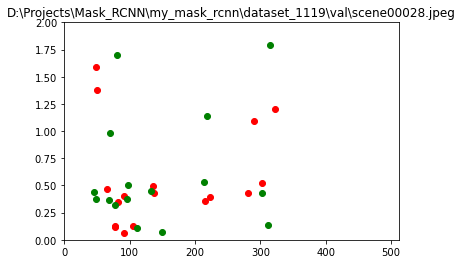

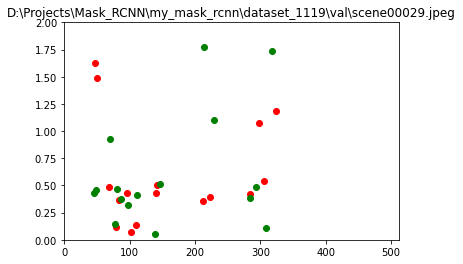

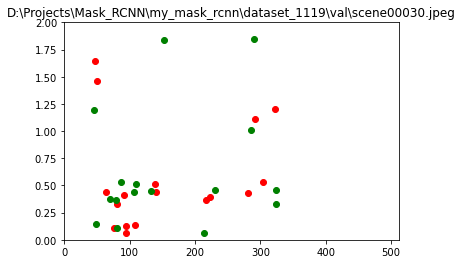

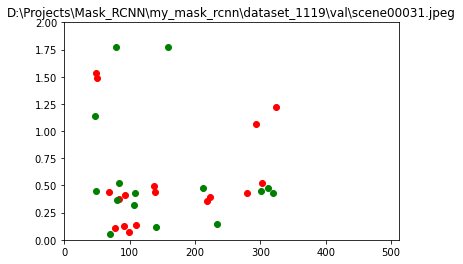

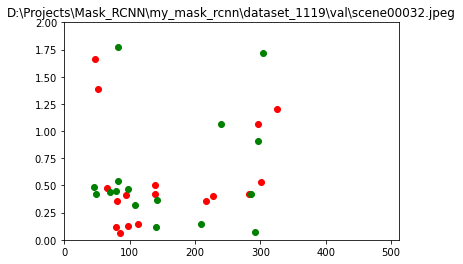

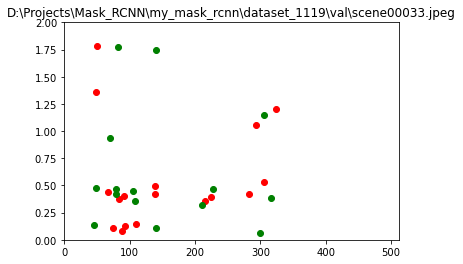

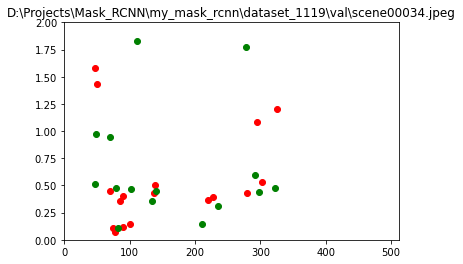

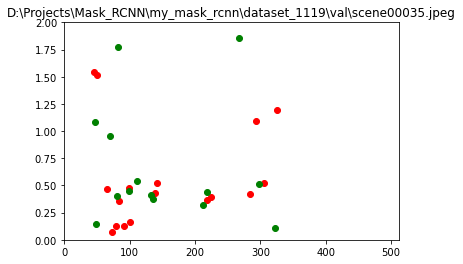

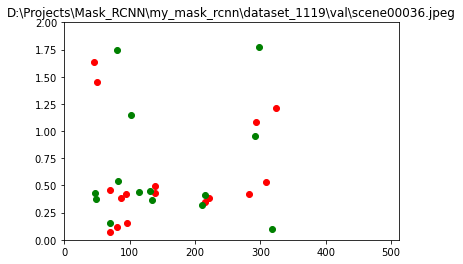

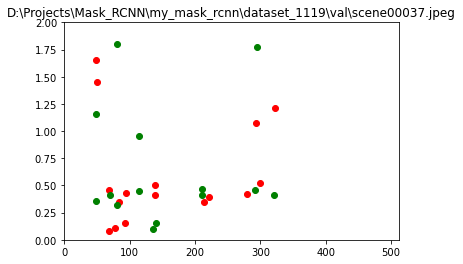

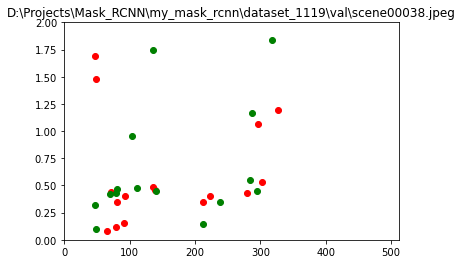

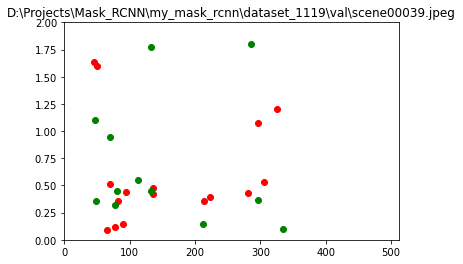

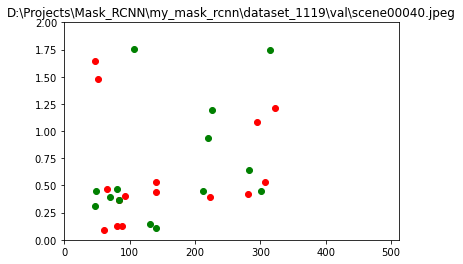

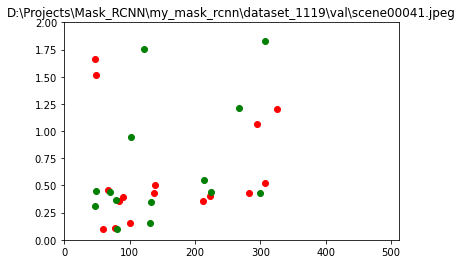

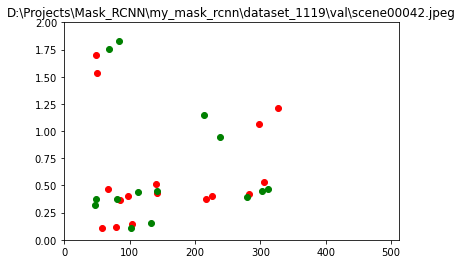

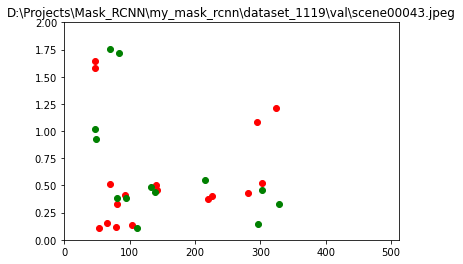

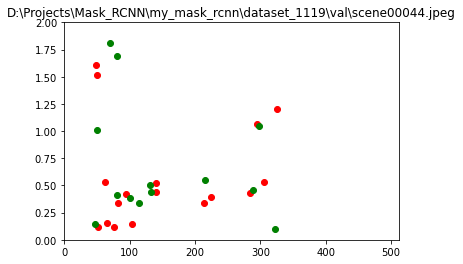

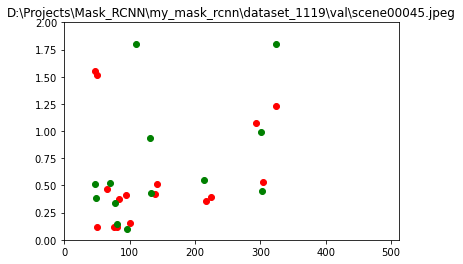

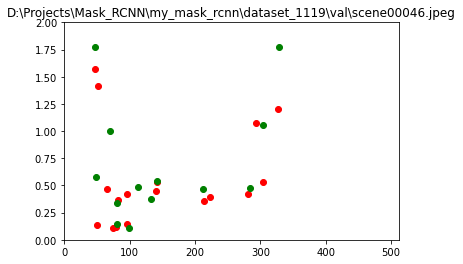

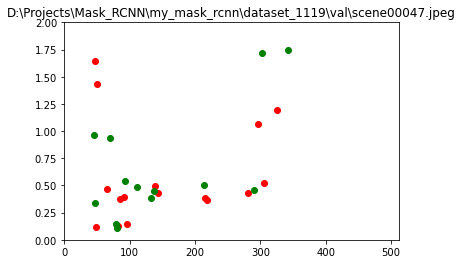

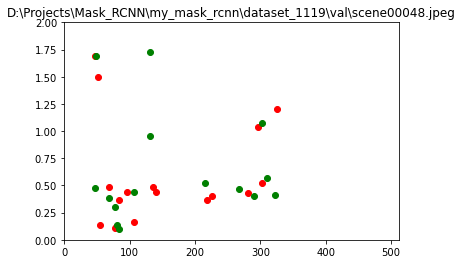

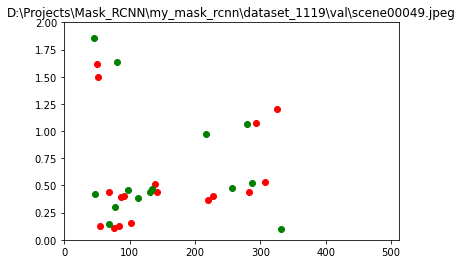

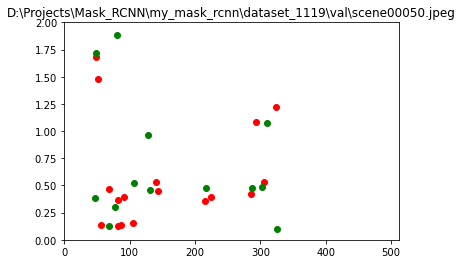

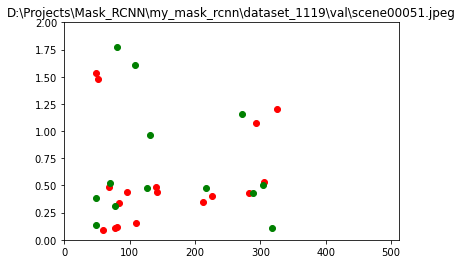

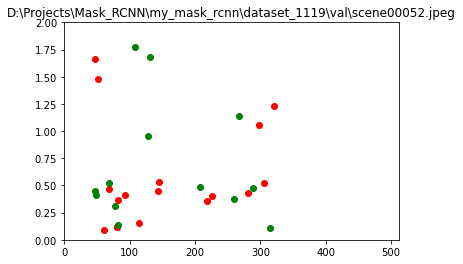

In [5]:
import matplotlib.pyplot as plt
for target in gt_targets:
    plt.title(target['file'])
    plt.plot(target['gt_sizes'], target['gt_wh_ratios'], 'ro')
    plt.plot(target['obj_sizes'], target['obj_wh_ratios'], 'go')
    plt.axis([0, 512, 0, 2])
    plt.show()


# 目标框

计算GT的bbox与检测的bbox的IoU。

2个目标怎么匹配？IoU最大的那个

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
for target in gt_targets:
    gt_boxes = [tuple(x['bbox']) for x in target['gts']]
    gt_boxes = np.array(gt_boxes)
    obj_boxes = [tuple(x['bbox']) for x in target['objs']]
    obj_boxes = np.array(obj_boxes)
    overlaps = utils.compute_overlaps(obj_boxes, gt_boxes)
    print(np.shape(overlaps))
    obj_bars = []
    gt_bars = []
    index_bars = []
    n_groups = len(obj_boxes)
    for i in range(0, n_groups):
        w = np.where(overlaps == max(overlaps[i,:]))
        # print(target['objs'][w[0][0]]['class_id'])
        # print(target['gts'][w[1][0]]['class_id'])
        obj = target['objs'][w[0][0]]
        gt = target['gts'][w[1][0]]
        obj_bars.append(obj['mask_area'])
        gt_bars.append(gt['mask_area'])
        index_bars.append(obj['class_id'])

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.35

    opacity = 0.4
    rects1 = ax.bar(index, obj_bars, bar_width,
                    alpha=opacity, color='b')

    rects2 = ax.bar(index + bar_width, gt_bars, bar_width,
                    alpha=opacity, color='r')

    ax.set_xlabel('类别')
    ax.set_ylabel('像素面积')
    ax.set_title(target['file'])
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(index_bars)
    ax.legend()

    fig.tight_layout()

plt.show()


(16, 17)
3
3
4
4
4
4
2
2
3
3
2
2
7
7
3
3
3
3
2
2
4
4
3
3
2
2
5
5
4
4
7
7
(16, 16)
3
3
4
4
4
4
2
2
7
7
3
3
3
3
2
2
2
2
2
2
3
3
3
3
4
4
5
5
4
4
7
7
(16, 17)
4
4
4
4
3
3
2
2
4
4
3
3
7
7
2
2
3
3
3
3
3
3
2
2
5
5
2
2
7
7
4
4
(15, 17)
2
2
4
4
4
4
3
3
3
3
2
2
3
3
2
2
3
3
4
4
5
5
3
3
7
7
2
2
7
7
(16, 17)
3
3
4
4
4
4
2
2
3
3
3
3
2
2
4
4
2
2
2
2
3
3
5
5
7
7
3
3
7
7
4
4
(15, 17)
4
4
3
3
2
2
4
4
3
3
3
3
2
2
4
4
2
2
3
3
2
2
5
5
4
4
3
3
7
7
(15, 17)
4
4
4
4
2
2
2
2
3
3
3
3
4
4
3
3
2
2
3
3
2
2
5
5
4
4
7
7
2
7
(14, 17)
4
4
4
4
3
3
3
3
2
2
3
3
2
2
4
4
3
3
2
2
2
2
5
5
4
4
7
7
(14, 16)
4
4
3
3
2
2
4
4
3
3
4
4
2
2
3
3
2
2
2
2
5
5
3
3
7
7
4
4
(14, 16)
4
4
4
4
2
2
3
3
2
2
4
4
3
3
3
3
2
2
3
3
5
5
2
2
4
4
7
7
(15, 16)
4
4
4
4
3
3
2
2
4
4
2
2
3
3
3
3
3
3
2
2
5
5
2
2
4
4
7
7
7
7
(12, 16)
4
4
4
4
3
3
2
2
2
2
4
4
3
3
3
3
2
2
5
5
4
4
3
3
(14, 15)
4
4
4
4
2
2
2
2
3
3
3
3
2
2
3
3
4
4
5
5
3
4
4
4
7
7
7
7
(14, 16)
4
4
4
4
2
2
3
3
3
3
2
2
3
3
2
2
3
3
4
4
5
5
2
2
4
4
7
7
(14, 16)
2
2
3
3
4
4
2
2
3
3
4
4
2
2
2
2
3
3
5
5
4

# 覆盖测试

人工不可能把所有目标的尺寸和宽高比逐个设置。现实做法是设置几个代表性的尺寸，如32、64、128。代表性的宽高比，如0.5、1、2

代表性数据不可能把所有目标都覆盖（IOU）

根据上述坐标图的数据分布情况，设置代表性尺寸、宽高比，在每个目标上标识最大的交并比（IOU）。

最大交并比（IOU）：理想值就是目标本身，但是以理想值为代表值，必然造成其它目标的交并比（IOU）下降。

三维坐标图：尺寸、宽高比、IOU

尺寸：锚框的正方形尺寸，应该从GT目标中挑选，把尺寸差值小于阈值的目标归为一组，将平均值作为锚框尺寸。目前网络设计，最多只有5个尺寸设置

宽高比：锚框的，也应该从GT目标中挑选。IoU：对所有目标的平均IoU，

理想状态是IOU值足够高（0~1），足以用于目标的过滤。

In [ ]:
# 变换GT目标框，求框尺寸之间的差值
for target in gt_targets:
    sizes = [x['size'] for x in target['gts']]
    len_size = len(sizes)
    row_matrix = np.tile(sizes, len_size) #扩充数据
    row_matrix.reshape(len_size, len_size) #NxN矩阵，行方式
    print(row_matrix)
    col_matrix = sizes.repeat(len_size) #扩充数据
    col_matrix.reshape(len_size, len_size) #NxN矩阵，列方式
    print(col_matrix)
    matrix = row_matrix - col_matrix   #尺寸之间的差值
    matrix = np.where(matrix >= 0, matrix, 0)   #过滤负值
    print(matrix)
    row1 = matrix.reshape(1, len_size*len_size)  #一维
    row1 = np.unique(row1)   #去重
    print(row1)
    for v in row1:
        w = np.where(matrix <= v)   #分组效果
        # 如果w中包含了所有的sizes元素，则循环结束
        if len(w[0]) >= len_size:
            # 对sizes元素分组
            # 把w[0]和w[1]联合，reshape成为Nx2的矩阵，等价于分成N组
            group2 = np.transpose(w)
            print(group2)   # Nx2矩阵
            # 组间存在交集则合并成为新组
            group3 = [group2[0]]
            for g2 in group2:
                for g3 in group3:
                    for x in g3:     #g2和g3的交集
                        if x in g2:
                            g3 = g3 + g2
                            break
                group3.append(g2)    #没有交集，新元素加入
            print(group3)

# 所有Anchor Box与GT目标的IoU

# 代表性的尺寸、宽高比挑选（实验性）

人工设置代表值达到IOU理想状态也不现实。。。

怎么让计算机挑选代表值？